## Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

## Importar Caras y Fondos

In [3]:
face_suffix = '.pgm'

face_files = os.listdir('Faces/')
pgm_files = [filename for filename in face_files if filename.endswith(face_suffix)]

faces = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  faces.append(image)

100%|██████████| 12833/12833 [00:02<00:00, 5304.40it/s]


In [4]:
faces = np.array(faces)
faces.shape

(12833, 64, 64)

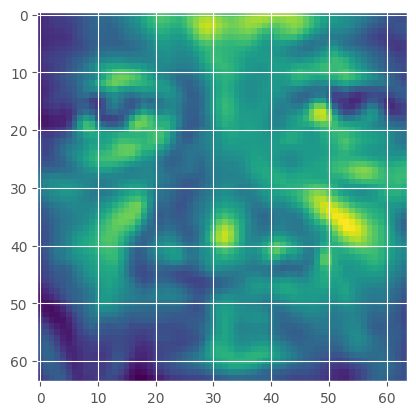

In [5]:
plt.imshow(faces[1])
plt.show()

In [6]:
background_suffix = '.png'

background_files = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in background_files if filename.endswith(background_suffix)]

backgrounds = []
for filename in tqdm(png_files):
  path = 'Generar_Fondos/generated_patches/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  backgrounds.append(image)

100%|██████████| 19200/19200 [00:04<00:00, 4201.20it/s]


In [7]:
backgrounds = np.array(backgrounds)
backgrounds.shape

(19200, 64, 64)

In [8]:
IMG_SIZE = (64, 64)  # Tamaño al que se redimensionarán las imágenes

face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        img_resized = resize(image, IMG_SIZE, anti_aliasing=True)
        positive_patches.append(img_resized.flatten())

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        img_resized = resize(image, IMG_SIZE, anti_aliasing=True)
        negative_patches.append(img_resized.flatten())
    

100%|██████████| 19200/19200 [00:06<00:00, 3167.70it/s]


In [9]:
positive_patches = np.array(positive_patches)
negative_patches = np.array(negative_patches)
negative_patches = (negative_patches*255).astype(np.uint8)
positive_patches = (positive_patches*255).astype(np.uint8)
print(positive_patches.shape)
print(negative_patches.shape)

(12833, 4096)
(19200, 4096)


In [10]:
positive_patches

array([[ 93, 109, 118, ..., 227, 240, 225],
       [ 68,  72,  76, ...,  94,  89,  88],
       [105, 109, 112, ..., 208, 147,  36],
       ...,
       [138, 142, 145, ...,  65,  11,  28],
       [109, 107, 110, ..., 124, 120, 109],
       [123,  86,  47, ...,  24,  46,  94]], dtype=uint8)

In [11]:
negative_patches

array([[217, 218, 218, ...,  31,  34,  35],
       [160, 160, 162, ...,  84,  85,  85],
       [105, 100,  92, ..., 134, 139, 146],
       ...,
       [175, 171, 161, ..., 124, 125, 127],
       [213, 213, 207, ..., 127, 101, 101],
       [214, 214, 213, ...,  81,  83,  83]], dtype=uint8)

In [12]:
# X = np.concatenate([faces, backgrounds])
# X = X.reshape(X.shape[0], -1) 
P = len(positive_patches)
X = np.array([im.flatten() for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
# X = (X*255).astype(np.uint8)
y = np.zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

Construyendo X: 32033it [00:00, 256719.87it/s]


In [13]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [14]:
X

array([[ 93, 109, 118, ..., 227, 240, 225],
       [ 68,  72,  76, ...,  94,  89,  88],
       [105, 109, 112, ..., 208, 147,  36],
       ...,
       [175, 171, 161, ..., 124, 125, 127],
       [213, 213, 207, ..., 127, 101, 101],
       [214, 214, 213, ...,  81,  83,  83]], dtype=uint8)

In [15]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [17]:
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

## PCA

In [18]:
# Entrenar el modelo con PCA al conjunto de entrenamiento
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=200)
X_train_pca = pca.fit(X_train_std)
X_train_pca_transform = pca.transform(X_train_std)
# X_train_pca_transform = pca.transform(X_train_pca)

In [19]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = X_train_pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

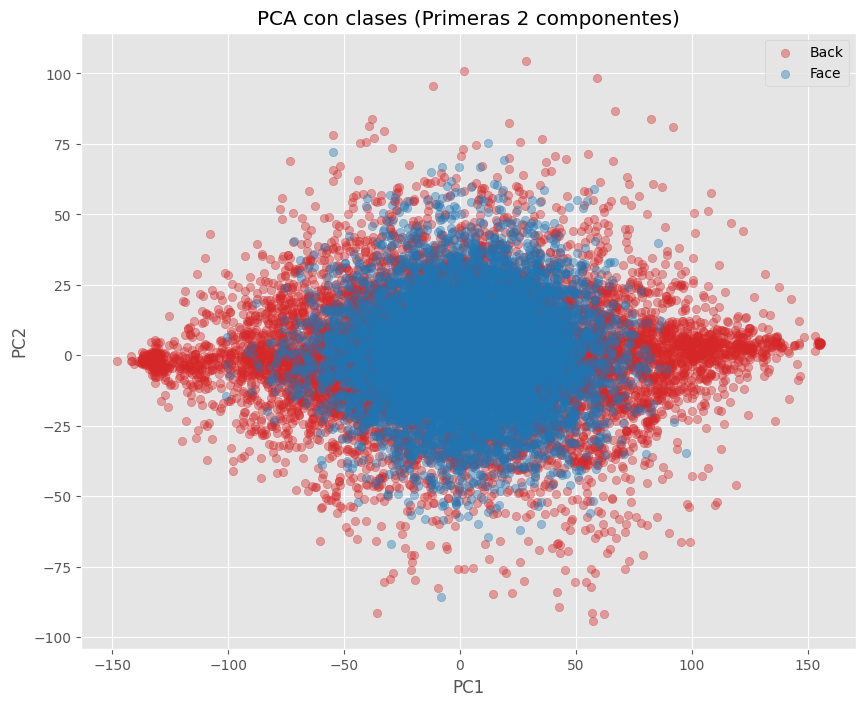

In [20]:
# Tomar solo las primeras dos componentes para graficar
X_plot = X_train_pca_transform[:, :2]

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

plt.figure(figsize=(10, 8))
for class_value in [0, 1]:
    plt.scatter(X_plot[y_train == class_value, 0], 
                X_plot[y_train == class_value, 1], 
                c=colors[class_value], 
                label=labels[class_value], 
                alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases (Primeras 2 componentes)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
joblib.dump(X_train_pca, 'models/pca_model.joblib')

['models/pca_model.joblib']

In [22]:
X_test_std = scaler.transform(X_test)

In [23]:
# Separar en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=42)

X_test_pca = pca.transform(X_test_std)

In [24]:
print(X_train_pca_transform.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(22423, 200)
(9610, 200)
(22423,)
(9610,)


In [25]:
#Algorimtos de clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from re import A


### KNN

In [26]:
# Elegimos el k
k = 3

In [27]:
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train_pca_transform, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [28]:
y_train_pred =knn.predict(X_train_pca_transform)
y_test_pred = knn.predict(X_test_pca)

print('Accuracy train:',accuracy_score(y_train,y_train_pred))
print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

Accuracy train: 0.9724836105784239
Accuracy test:  0.9537981269510926


In [29]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     13489
         1.0       1.00      0.93      0.96      8934

    accuracy                           0.97     22423
   macro avg       0.98      0.97      0.97     22423
weighted avg       0.97      0.97      0.97     22423



In [30]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      5711
         1.0       0.99      0.89      0.94      3899

    accuracy                           0.95      9610
   macro avg       0.96      0.94      0.95      9610
weighted avg       0.96      0.95      0.95      9610



In [31]:
joblib.dump(knn, 'models/knn_model.joblib')

['models/knn_model.joblib']

## HOG

In [32]:
from skimage.feature import hog
from sklearn.svm import LinearSVC


In [33]:
IMG_SIZE = (64, 64)  # Tamaño al que se redimensionarán las imágenes

face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image_norm = (image*255).astype(np.uint8)
        hog_feature = hog(image_norm, feature_vector=True)
        positive_patches.append(hog_feature)

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image_norm = (image*255).astype(np.uint8)
        hog_feature = hog(image_norm, feature_vector=True)
        negative_patches.append(hog_feature)

100%|██████████| 19200/19200 [00:12<00:00, 1499.84it/s]


In [34]:
image_norm

array([[214, 214, 213, ..., 219, 221, 221],
       [214, 214, 213, ..., 219, 221, 221],
       [216, 216, 215, ..., 220, 223, 223],
       ...,
       [ 77,  77,  69, ...,  74,  76,  76],
       [ 69,  69,  64, ...,  81,  83,  83],
       [ 69,  69,  64, ...,  81,  83,  83]], dtype=uint8)

In [35]:
P = len(positive_patches)
X = np.array(positive_patches + negative_patches)
# X = (X*255).astype(np.uint8)
y = np.zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

In [36]:
X.shape

(32033, 2916)

In [37]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [40]:
X_train.shape

(25626, 2916)

In [41]:
X_train_std.shape

(25626, 2916)

In [42]:
# scaler
joblib.dump(scaler, 'models/scaler_hog.joblib')

['models/scaler_hog.joblib']

In [43]:
pca_hog = PCA(n_components=500, whiten=True).fit(X_train_std)

In [44]:
joblib.dump(pca_hog, 'models/pca_hog.joblib')

['models/pca_hog.joblib']

In [45]:
X_train_pca = pca_hog.transform(X_train_std)

In [ ]:
# # Entrenar modelo
# clf = LinearSVC()
# clf.fit(X_train_pca, y_train)

/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

## Gaussian Naive Bayes

In [71]:
model = GaussianNB()

In [72]:
model.fit(X_train_pca, y_train)

GaussianNB()

In [73]:
X_test_std = scaler.transform(X_test)

In [74]:
X_test_pca = pca_hog.transform(X_test_std)

In [75]:
# Evaluar
y_pred = model.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9565047786229764
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      2527
         1.0       0.98      0.94      0.96      2600

    accuracy                           0.96      5127
   macro avg       0.96      0.96      0.96      5127
weighted avg       0.96      0.96      0.96      5127



In [76]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2466   61]
 [ 162 2438]]


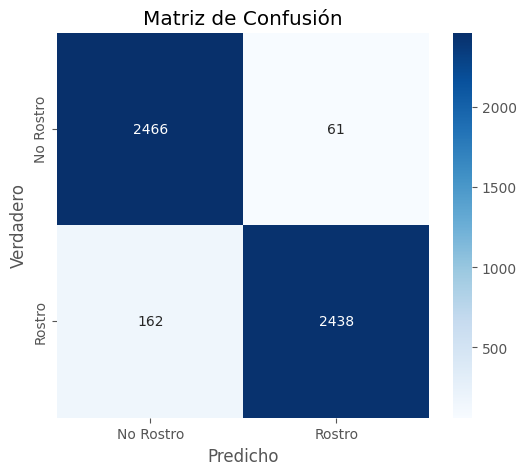

In [77]:
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rostro', 'Rostro'], yticklabels=['No Rostro', 'Rostro'])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [78]:
joblib.dump(model, 'models/naive_bayes_hog.joblib')

['models/naive_bayes_hog.joblib']

## Aplicando Optuna

In [18]:
from sklearn.model_selection import cross_val_score
import optuna

In [35]:
# Define the objective function for Optuna optimization (KNN and n_positive_samples)
def objective(trial):
    # Hyperparameters to optimize for n_positive_samples
    # Ensuring minimum samples for both positive and negative classes in splits
    n_positive_samples = trial.suggest_int('n_positive_samples', 2000, len(positive_patches), step=1000)

    # Hyperparameters to optimize for KNN
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean']) # Simplified metrics to avoid 'p' parameter complexity for now

    try:
        # --- Data Preparation inside the objective ---
        # Select a subset of positive patches
        current_positive_patches = positive_patches[:n_positive_samples]

        # Combine positive and negative patches to form the full dataset
        # Ensure we have enough negative patches to balance if n_positive_samples is large
        # For simplicity, we are still using all negative_patches, ensure current_positive_patches + negative_patches is not too small
        # if len(current_positive_patches) == 0:
        #     return 0.0 # Return a bad score if no positive samples are selected

        X_full = np.array([feature.hog(im) for im in chain(current_positive_patches, negative_patches)])
        y_full = np.zeros(len(X_full))
        y_full[:len(current_positive_patches)] = 1

        # # Check if X_full has enough samples for splitting
        # if len(X_full) < 2: # Need at least 2 samples for train_test_split (one for train, one for test)
        #     return 0.0 # Return a bad score if not enough total samples

        # Split data into training and validation sets
        X_train_trial, X_val_trial, y_train_trial, y_val_trial = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full) # Added stratify for balanced splits

        # Check if splits are valid
        # if len(X_train_trial) == 0 or len(X_val_trial) == 0:
        #     return 0.0 # Return a bad score if splits are empty

        # Scale the features
        scaler_trial = StandardScaler()
        X_train_std_trial = scaler_trial.fit_transform(X_train_trial)

        # Apply PCA (fixed parameters as per previous discussion, n_components=500, whiten=True)
        # Ensure n_components is less than or equal to n_samples in X_train_std_trial
        # n_components_pca = min(500, X_train_std_trial.shape[0], X_train_std_trial.shape[1])
        # if n_components_pca < 1: # PCA needs at least one component
        #     return 0.0

        pca_trial = PCA(n_components=500, whiten=True)
        X_train_pca_trial = pca_trial.fit_transform(X_train_std_trial)
        # --- End Data Preparation ---

        # Create and train KNeighborsClassifier with suggested parameters
        from sklearn.neighbors import KNeighborsClassifier # Ensure KNeighborsClassifier is imported within the function for safety
        model_trial = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

        # Use cross-validation to evaluate the model
        cv_scores = cross_val_score(model_trial, X_train_pca_trial, y_train_trial,
                                   cv=5, scoring='f1', n_jobs=-1)

        # Return the mean cross-validation score
        return cv_scores.mean()

    except Exception as e:
        # Catch any unexpected errors during data preparation or model training
        # print(f"Error in trial {trial.number}: {e}") # Optional: uncomment to see error details during optimization
        return 0.0 # Return a very low score for failed trials

In [36]:
# Create a study object and optimize
print("Starting hyperparameter optimization with Optuna...")
# We want to maximize the F1-score, so direction='maximize'
study = optuna.create_study(direction='maximize')
# Run the optimization for 50 trials (you can increase this for better results)
study.optimize(objective, n_trials=50, show_progress_bar=True) # show_progress_bar=True added for visual progress

print("\nOptimization completed!")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best F1-score: {study.best_value:.4f}")
print("Best parameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-06-21 13:14:21,426] A new study created in memory with name: no-name-9c9bd7a4-f8cc-465a-8733-767135e4337e


Starting hyperparameter optimization with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [2000, 12833] and step=1000, but the range is not divisible by `step`. It will be replaced by [2000, 12000].
  warnings.warn(


[I 2025-06-21 13:14:21,442] Trial 0 finished with value: 0.0 and parameters: {'n_positive_samples': 7000, 'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2025-06-21 13:14:21,446] Trial 1 finished with value: 0.0 and parameters: {'n_positive_samples': 11000, 'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2025-06-21 13:14:21,456] Trial 2 finished with value: 0.0 and parameters: {'n_positive_samples': 4000, 'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2025-06-21 13:14:21,462] Trial 3 finished with value: 0.0 and parameters: {'n_positive_samples': 6000, 'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.0.
[I 2025-06-21 13:14:21,465] Trial 4 finished with value: 0.0 and parameters: {'n_positive_samples': 10000, 'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}. Best is tr

In [ ]:
# Train the final KNN model with the best parameters
best_params = study.best_params

# Re-prepare the data using the best n_positive_samples
final_n_positive_samples = best_params['n_positive_samples']
final_current_positive_patches = positive_patches[:final_n_positive_samples]

# Combine positive and negative patches to form the full dataset
X_final_full = np.array([feature.hog(im) for im in chain(final_current_positive_patches, negative_patches)])
y_final_full = np.zeros(len(X_final_full))
y_final_full[:len(final_current_positive_patches)] = 1

# Split data into training and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final_full, y_final_full, test_size=0.2, random_state=42)

# Scale the features
scaler_final = StandardScaler()
X_train_std_final = scaler_final.fit_transform(X_train_final)
X_val_std_final = scaler_final.transform(X_val_final) # Scale validation data too

# Apply PCA (fixed parameters: 500 components, whiten=True)
pca_final = PCA(n_components=500, whiten=True)
X_train_pca_final = pca_final.fit_transform(X_train_std_final)
X_val_pca_final = pca_final.transform(X_val_std_final) # Transform validation data

# Create and train KNeighborsClassifier with best parameters
from sklearn.neighbors import KNeighborsClassifier # Ensure KNeighborsClassifier is imported
model_optimized = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                                       weights=best_params['weights'],
                                       metric=best_params['metric'])
model_optimized.fit(X_train_pca_final, y_train_final)

print("Optimized KNN model trained successfully with best parameters!")
print(f"Best n_positive_samples: {best_params['n_positive_samples']}")
print(f"Best n_neighbors: {best_params['n_neighbors']}")
print(f"Best weights: {best_params['weights']}")
print(f"Best metric: {best_params['metric']}")

# Save Models Full